In [1]:
import torch as th
import optuna

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from params import default_params, set_tsp_params
from experiments.actor_critic_experiment import ActorCriticExperiment
from controllers.ac_controller import ActorCriticController
from learners.reinforce_learner import ReinforceLearner
from generators.tsp_generator import TSPGenerator

In [2]:
# Get params
params = default_params()

# Set TSP params
max_nodes_per_graph = 10
embedding_dimension = 4
max_episodes = 500
# rollouts_in_batch = 50
instance = 0

params['problem'] = 'tsp'
params['node_dimension'] = 2
params['embedding_dimension'] = embedding_dimension
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['max_episodes'] = max_episodes


# Create network
basic_network = BasicNetwork(max_nodes_per_graph = params['max_nodes_per_graph'], 
                            node_dimension = params['node_dimension'], 
                            embedding_dimension = params['embedding_dimension'])

# Create environment
tsp_generator = TSPGenerator()
# cities = tsp_generator.generate_instance(max_nodes_per_graph)
# cities = th.tensor([[0.0, 0.0], [0.1, 0.1], [0.2, 0.2], [0.3, 0.3], [0.4, 0.4]], dtype=th.float32)
cities = th.load(f"training/tsp/size_{max_nodes_per_graph}/instance_{instance}.pt") 
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(basic_network)
learner = ReinforceLearner(model = basic_network, controller = controller, params = params)

# Create the experiment
experiment = ActorCriticExperiment(params = params, model = basic_network, env = env, learner = learner)

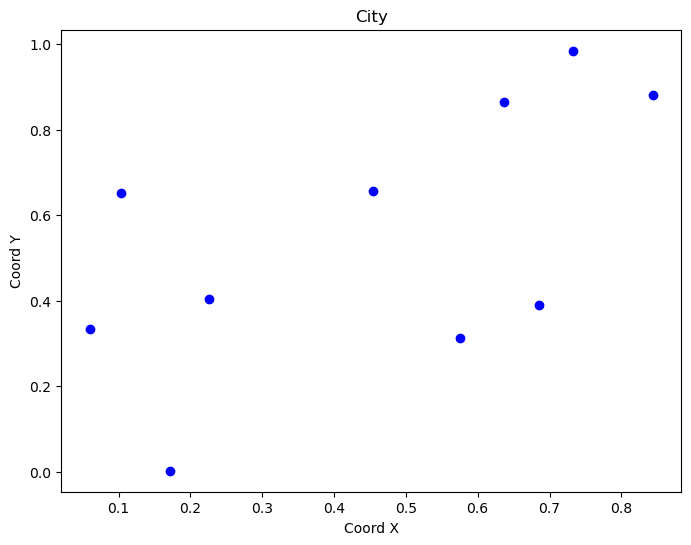

In [3]:
tsp_generator.plot_instance(cities=cities)

In [ ]:
def objective(trial):
    # Define the hyperparameters as trial suggestions
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    entropy_weight = trial.suggest_float('entropy_weight', 0, 1)
    rollouts_in_batch = trial.suggest_int('rollouts_in_batch', 1, 100)
    pct_epsilon_anneal_time = trial.suggest_float('pct_epsilon_anneal_time', 0.5, 1)
    epsilon_start = trial.suggest_float('epsilon_start', 0, 1)
    epsilon_finish = trial.suggest_float('epsilon_finish', 0, 1)
    entropy_regularization = trial.suggest_categorical('entropy_regularization', [True, False])

    # Use these parameters to create components
    params['batch_size'] = (max_nodes_per_graph + 1) * rollouts_in_batch
    params['max_steps'] = params['max_episodes'] * (max_nodes_per_graph + 1) * rollouts_in_batch
    params['epsilon_start'] = epsilon_start
    params['epsilon_finish'] = epsilon_finish
    params['epsilon_anneal_time'] = pct_epsilon_anneal_time * params['max_steps']
    params['entropy_regularization'] = entropy_regularization
    params['entropy_weight'] = entropy_weight
    params['lr'] = lr
    params['plot_frequency'] = None


    basic_network = BasicNetwork(max_nodes_per_graph=params['max_nodes_per_graph'], 
                                 node_dimension=params['node_dimension'], 
                                 embedding_dimension=params['embedding_dimension'])
    env = EnviornmentTSP(cities=cities, max_nodes_per_graph=params['max_nodes_per_graph'], 
                         node_dimension=params['node_dimension'])
    controller = ActorCriticController(basic_network)
    learner = ReinforceLearner(model=basic_network, controller=controller, params=params)
    experiment = ActorCriticExperiment(params=params, model=basic_network, env=env, learner=learner)

    # Perform training and return the evaluation metric
    final_metric = experiment.run()  # Assume `run` returns a performance indicator
    return final_metric

study = optuna.create_study(direction='maximize')  # or 'minimize' if you're minimizing a metric
study.optimize(objective, n_trials=25)  # You can adjust the number of trials

[I 2024-04-21 12:58:44,552] A new study created in memory with name: no-name-ac9f00ab-ffa3-4f1c-a778-22c5478d9516
[I 2024-04-21 13:05:03,474] Trial 0 finished with value: -5.436618804931641 and parameters: {'lr': 3.734395015352074e-05, 'entropy_weight': 0.43725295474440906, 'rollouts_in_batch': 61, 'pct_epsilon_anneal_time': 0.8370023983707295, 'epsilon_start': 0.6440897595128013, 'epsilon_finish': 0.6927141045986364, 'entropy_regularization': True}. Best is trial 0 with value: -5.436618804931641.
[I 2024-04-21 13:07:16,376] Trial 1 finished with value: -6.249627113342285 and parameters: {'lr': 0.06424440237616155, 'entropy_weight': 0.07921741418960249, 'rollouts_in_batch': 22, 'pct_epsilon_anneal_time': 0.5722375147288337, 'epsilon_start': 0.7795202872155989, 'epsilon_finish': 0.31005637515259277, 'entropy_regularization': True}. Best is trial 0 with value: -5.436618804931641.
[I 2024-04-21 13:09:34,325] Trial 2 finished with value: -5.390800952911377 and parameters: {'lr': 6.63342822

In [ ]:
# Run the experiment
experiment.run()

In [ ]:
experiment.plot_rollout()